In [1]:
import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

# ベータ分布
まず確率密度関数としてベータ分布を考える。ベータ分布の確率密度関数は、
$$
\begin{align}
p(x|\alpha, \beta) = \frac{x^{\alpha -1} (1-x)^{\beta - 1} }{ B(\alpha,\beta)}\\
0 \leq x \leq 1, \alpha > 0, \beta > 0 \\
B(\alpha, \beta ) = \int_0^1 x^{\alpha -1 } (1-x)^{\beta-1} dx
\end{align}
$$
である。いろいろな$\alpha, \beta$にたいして確率密度関数(PDF: Possibility Distribution Function)をプロットすると以下の通り。


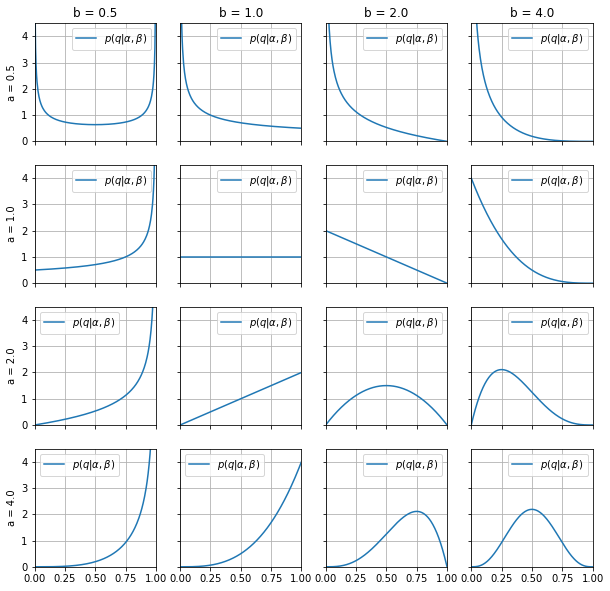

In [7]:
q = np.linspace(0, 1, 250)
value_a = np.array([0.5, 1.0, 2.0, 4.0])
value_b = np.array([0.5, 1.0, 2.0, 4.0])
rows = value_a.shape[0]
cols = value_b.shape[0]
fig, ax = plt.subplots(rows, cols, figsize=(10, 10), sharex='all', sharey='all')

ax[0,0].set_xlim(0, 1)
ax[0,0].set_ylim(0, 4.5)

for row_index in range(rows):
    a = value_a[row_index]
    ax[row_index, 0].set_ylabel('a = {}'.format(a))
    for col_index in range(cols):
        b = value_b[col_index]
        ax[row_index, col_index].plot(q, st.beta.pdf(q, a, b), label=r'$p(q|\alpha, \beta)$')
        ax[row_index, col_index].legend()
        ax[row_index, col_index].grid()
        if row_index==0:
            ax[0, col_index].set_title('b = {}'.format(b))
            

横軸$q$は運よく内閣支持者を引き当てることができる確率、成功確率である。

# ベイズの定理
成功確率$q$と、データ$D={x_1, ..., x_n}$の組み合わせが同時に実現する確率$p(q, D)$について、
$$
p(q, D) = p(q|D) p(D) = p(D|q) p(q)
$$
であるから、
$$
p(q|D) = \frac{p(D|q)p(q)}{p(D)}
$$
である。これがベイズの定理である。

右辺の分子$p(D|q)$は、「仮に成功確率が$q$であったときにデータ$D$が実際に観測される確率」であり、$D$を生成した確率分布そのものである。
$D$の各要素はベルヌーイ分布
$$
\begin{align}
p(x_i) &= q^{x_i} (1-q)^{1-x_i} \\
(x_i &= \{ 0, 1\})
\end{align}
$$
で与えられるので、
$$
\begin{align}
p(D|q) &= \prod_{i=1}^{n} q_i (1-q)^{1-x_i} = q^y (1-q)^{n-y} \\
(y &= \sum_{i=1}^{n} x_i)
\end{align}
$$

また分母$p(D)$を見ると
$$
p(D) = \int_0^1 p(D, q) dq = \int_0^1 p(D|q) p(q) dq
$$
と書けるので、$p(D)$は「事前分布を$p(q)$を仮定したときの、データ$D$が観測される平均的な可能性」と解釈することができる。

以上を踏まえると、ベイズの定理は、
「事前分布$p(q)$に対して、データによる更新のファクター$\frac{p(D|q)}{p(D)}$を掛けて、事後分布$p(q|D)$を得る。」
のように解釈することができる。

$p(D)$はデータが観測された後では固定されてしまうので、ベイズの定理を比例式として
$$
p(q|D) \propto p(D|q) p(q)
$$
のように書くことができる。



今回、事前分布として$\alpha=\alpha_0, \beta=\beta_0$のベータ分布を与えるとすると、
$$
\begin{align}
p(q|D) \propto p(D|q) p(q) 
&\propto q^y (1-q)^{n-y} \times \frac{q^{\alpha_0 - 1} (1-q)^{\beta_0 -1}}{B(\alpha_0, \beta_0)} \\
&\propto q^{y+\alpha_0-1} (1-q)^{n-y+\beta_0-1}
\end{align}
$$

規格化定数も含めれば
$$
\begin{align}
&p(q|D) = \frac{q^{\alpha_*-1} (1-q)^{\beta_*-1}}{B(\alpha_*, \beta_*)}, \\
&\alpha_* = y + \alpha_0, \\
&\beta_* = n - y + \beta_0 \\
\end{align}
$$

In [15]:
def bernoulli_stats(data, a0, b0, prob):
    """
    Inuput:
        data: data (0 or 1)
        a0: alpha of prior
        b0: beta of prior
        prob: credible interval
    Returns:
        resutlts: pandas dataframe
        a: alpha of posterior
        b: beta of posterior
    """
    n = data.size
    sum_data = np.sum(data)
    a = sum_data + a0
    b = n - sum_data + b0
    mean_pi = st.beta.mean(a, b)
    median_pi = st.beta.median(a, b)
    mode_pi = (a - 1) / (a + b - 2)
    sd_pi = st.beta.std(a, b)
    ci_pi = st.beta.interval(prob, a, b)

    stats = np.hstack((mean_pi, median_pi, mode_pi, sd_pi, ci_pi))
    stats = stats.reshape((1, 6))
    stats_string = ['mean', 'median', 'mode', 'sd', 'CI (lower)', 'CI (upper)']
    
    param_string = ['possibliity of success (q)']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results, a, b

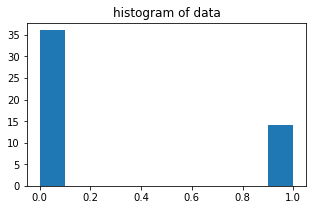

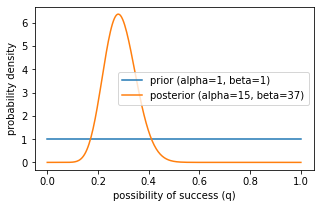

In [27]:
# generate data
p = 0.25
n = 50
np.random.seed(99)
data = st.bernoulli.rvs(p, size=n)
#plot histogram
plt.figure(figsize=(5, 3))
plt.hist(data)
plt.title('histogram of data')
plt.show()

# calculate stats
a0 = 1 # uniform prior
b0 = 1 # uniform prior
prob = 0.95 # credible interval
results, a, b = bernoulli_stats(data, a0, b0, prob)
# plot probability density functions
fig1 = plt.figure(figsize=(5, 3))
q = np.linspace(0, 1, 250)
plt.plot(q, st.beta.pdf(q, a0, b0), label=f'prior (alpha={a0}, beta={b0})')
plt.plot(q, st.beta.pdf(q, a, b), label=f'posterior (alpha={a}, beta={b})')
plt.xlabel('possibility of success (q)')
plt.ylabel('probability density')
plt.legend()
plt.show()


(array([36.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

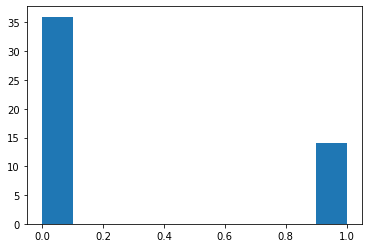

In [18]:
# plot several prior distributions
fig2 = plt.figure(figsize=(5, 3))
q = np.linspace(0, 1, 250)
a0_1 ,b0_1 = 1, 1



